# Model to predict booking prices on Airbnb using linear regression

# Import libraries

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor #Handling multicollinearity
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter

# Loading dataset

In [187]:
data = pd.read_csv(r'C:\Users\Victo\Downloads\Compressed\AB_NYC_2019.csv.zip')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [188]:
#Information on the dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [189]:
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


# Data pre-processing

# Extract dependent and independent variables from the dataset

In [190]:
data.dropna(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38821 entries, 0 to 48852
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              38821 non-null  int64  
 1   name                            38821 non-null  object 
 2   host_id                         38821 non-null  int64  
 3   host_name                       38821 non-null  object 
 4   neighbourhood_group             38821 non-null  object 
 5   neighbourhood                   38821 non-null  object 
 6   latitude                        38821 non-null  float64
 7   longitude                       38821 non-null  float64
 8   room_type                       38821 non-null  object 
 9   price                           38821 non-null  int64  
 10  minimum_nights                  38821 non-null  int64  
 11  number_of_reviews               38821 non-null  int64  
 12  last_review                     38821

# Handling missing data

In [191]:
data = data.drop(['id','name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38821 entries, 0 to 48852
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        38821 non-null  float64
 1   longitude                       38821 non-null  float64
 2   price                           38821 non-null  int64  
 3   minimum_nights                  38821 non-null  int64  
 4   number_of_reviews               38821 non-null  int64  
 5   reviews_per_month               38821 non-null  float64
 6   calculated_host_listings_count  38821 non-null  int64  
 7   availability_365                38821 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 2.7 MB


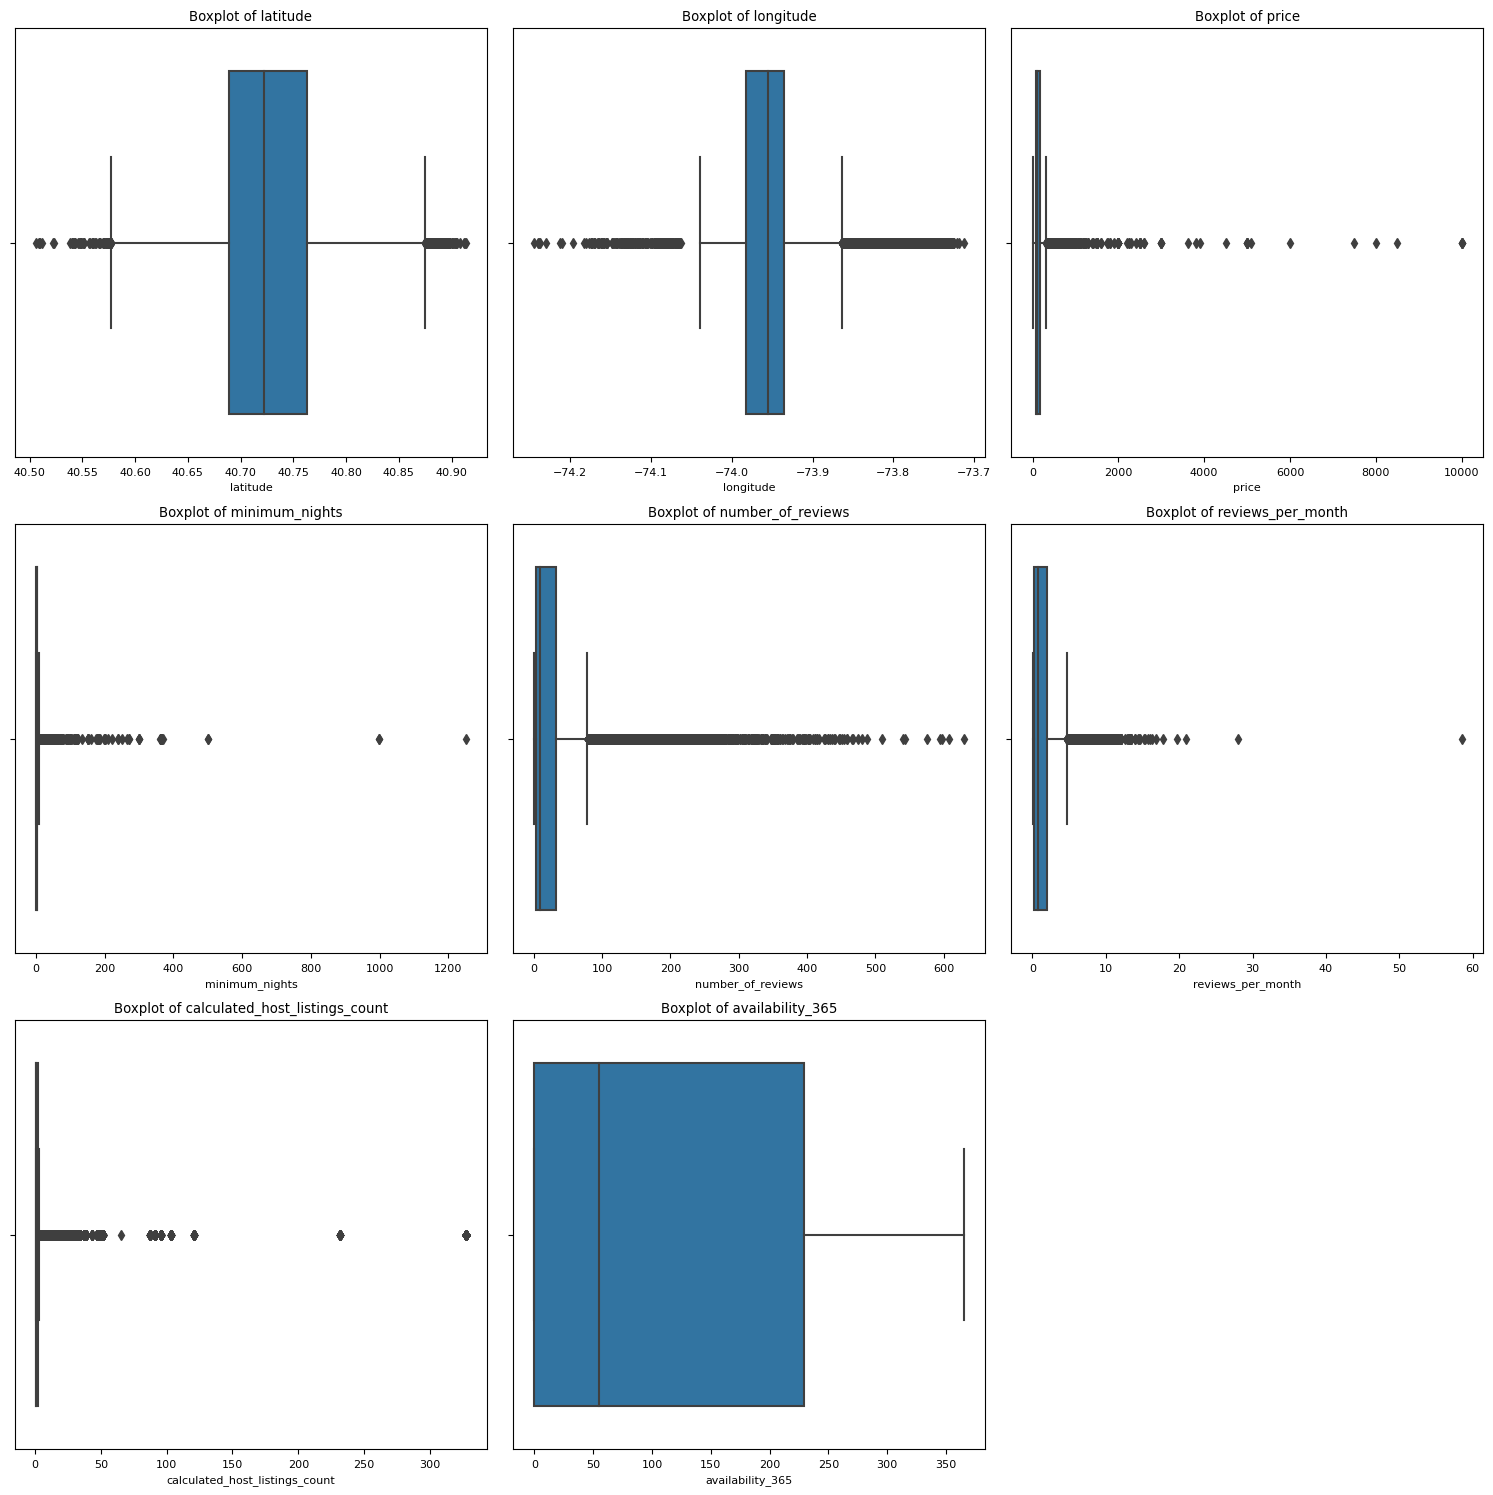

In [192]:
import warnings

# To suppress all warnings:
warnings.filterwarnings('ignore')

#Checking distributions of the various features in the dataset

num_cols = data.shape[1]
num_rows = (num_cols + 2) // 3  # Calculate the number of rows needed

plt.figure(figsize=(15, 5 * num_rows))  # Adjust the figure size based on the number of rows

for i, col in enumerate(data, 1):
    if data[col].dtype != 'object':
        plt.subplot(num_rows, 3, i)  # 3 columns per row
        sns.boxplot(x=data[col], orient='vertical')
        plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

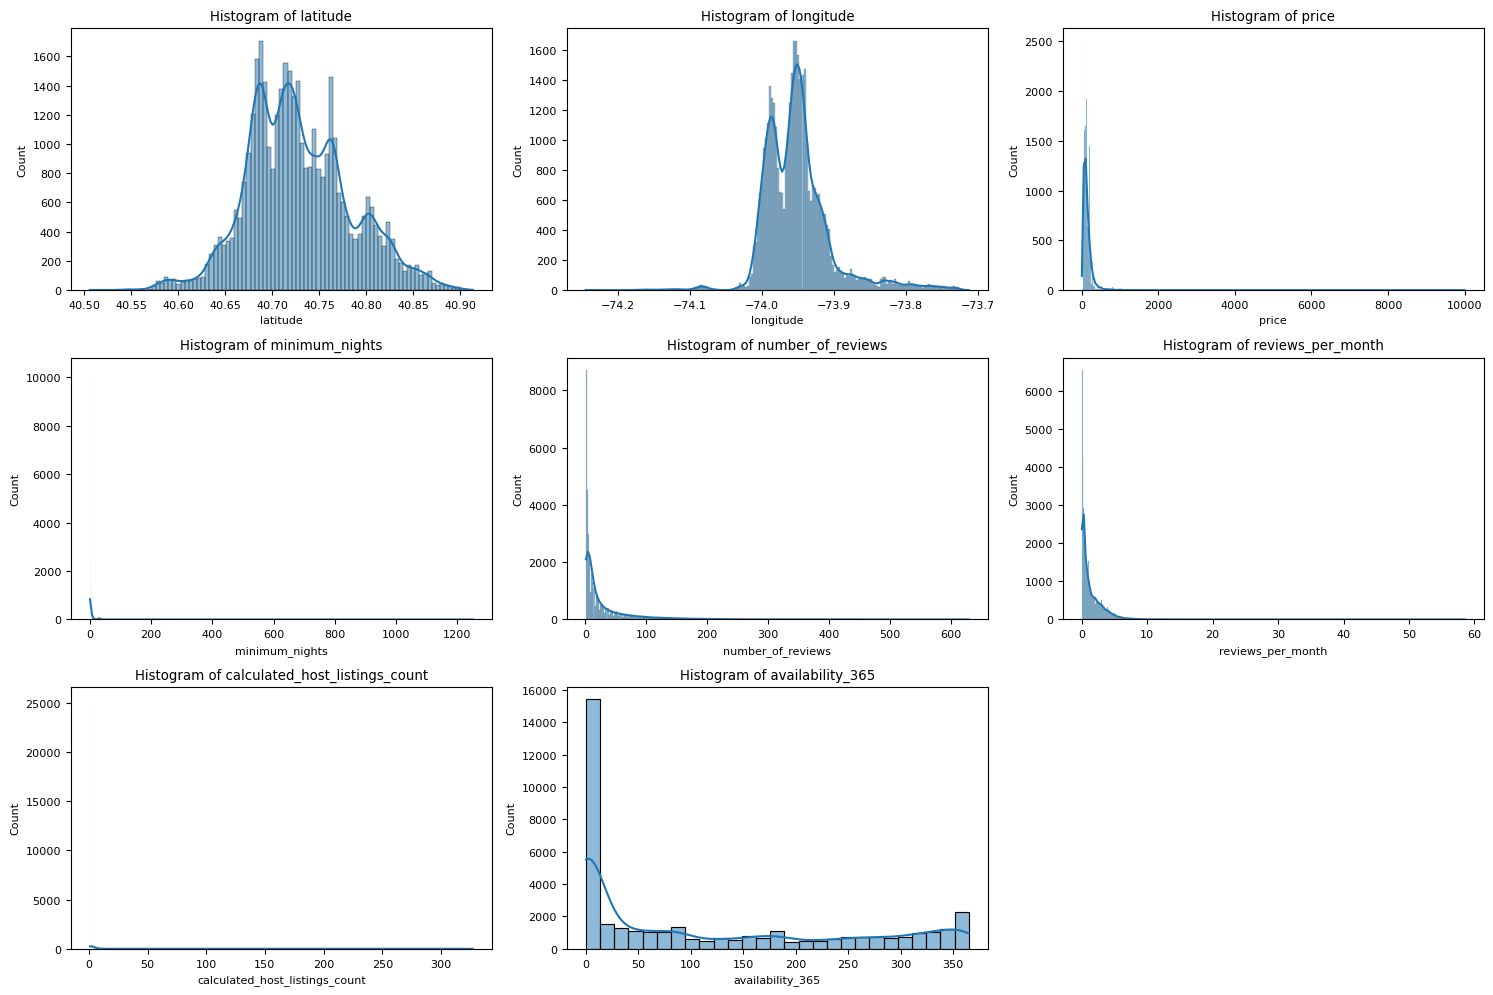

In [193]:

plt.figure(figsize=(15, 10))

for i, col in enumerate(data, 1):
    if data[col].dtype != 'object':
        plt.subplot(num_rows, 3, i) 
        sns.histplot(data[col], kde=True)  # Create a histogram with a kernel density estimate
        plt.title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [194]:
# Identify and filter categorical columns
categorical_cols = [col for col in data.columns if data[col].dtype == 'object']

# Calculate the number of rows needed based on the number of categorical columns
num_col = len(categorical_cols)
num_row = (num_col + 2) // 3  # Calculate the number of rows needed

plt.figure(figsize=(15, 5 * num_row))  # Adjust the figure size based on the number of rows

data_set = data

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(num_row, 3, i)  # 3 columns per row
    sns.countplot(data=data_set, x=col)
    plt.title(f'Count Plot of {col}')

plt.tight_layout()

plt.show()

<Figure size 1500x0 with 0 Axes>

In [195]:
le = LabelEncoder()

for col in data.columns:
    if data[col].dtype == 'bool':
        print(f"Column '{col}' is boolean and will be converted to binary using LabelEncoder.")
        
        # Fit and transform the LabelEncoder on the column
        data[col] = le.fit_transform(data[col])

data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
3,40.68514,-73.95976,89,1,270,4.64,1,194
4,40.79851,-73.94399,80,10,9,0.10,1,0
5,40.74767,-73.97500,200,3,74,0.59,1,129


In [196]:
data.corr()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,0.088259,0.031344,0.024893,-0.008559,-0.010117,0.004340,-0.021921
longitude,0.088259,1.000000,-0.155298,-0.055414,0.054746,0.146228,-0.093348,0.102573
price,0.031344,-0.155298,1.000000,0.025501,-0.035924,-0.030623,0.052895,0.078276
minimum_nights,0.024893,-0.055414,0.025501,1.000000,-0.069366,-0.121712,0.073474,0.101658
number_of_reviews,-0.008559,0.054746,-0.035924,-0.069366,1.000000,0.549699,-0.059796,0.193409
reviews_per_month,-0.010117,0.146228,-0.030623,-0.121712,0.549699,1.000000,-0.009442,0.185896
calculated_host_listings_count,0.004340,-0.093348,0.052895,0.073474,-0.059796,-0.009442,1.000000,0.182981
availability_365,-0.021921,0.102573,0.078276,0.101658,0.193409,0.185896,0.182981,1.000000


In [197]:
x = data.drop(['price'], axis=1)
y = data['price']

correlation = x.corrwith(y)
print(correlation)


latitude                          0.031344
longitude                        -0.155298
minimum_nights                    0.025501
number_of_reviews                -0.035924
reviews_per_month                -0.030623
calculated_host_listings_count    0.052895
availability_365                  0.078276
dtype: float64


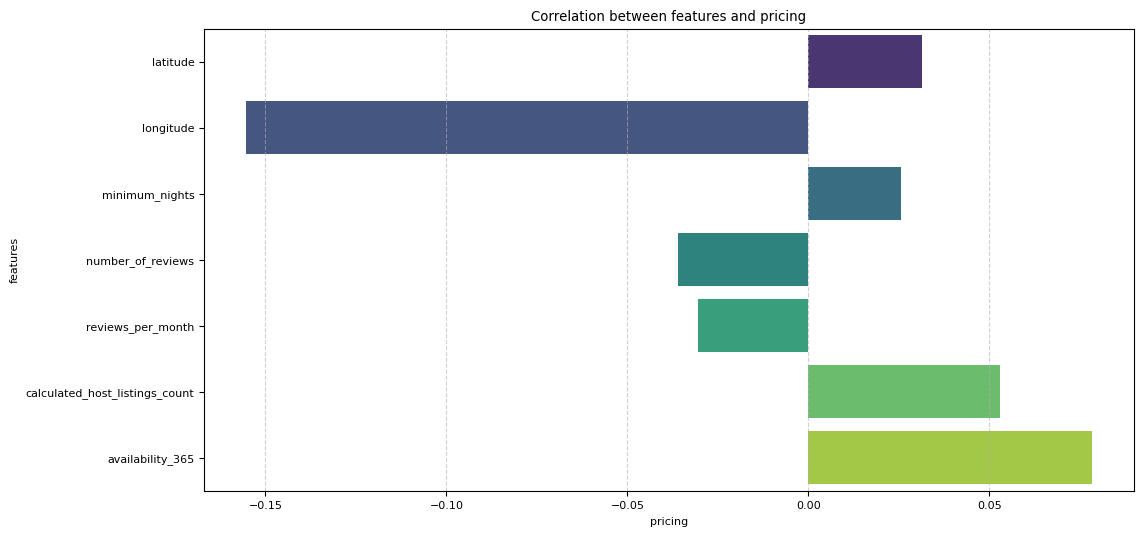

In [198]:
plt.figure(figsize=(12, 6))
sns.barplot(x=correlation.values, y=correlation.index, palette="viridis")
plt.xlabel('pricing')
plt.ylabel('features')
plt.title('Correlation between features and pricing')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

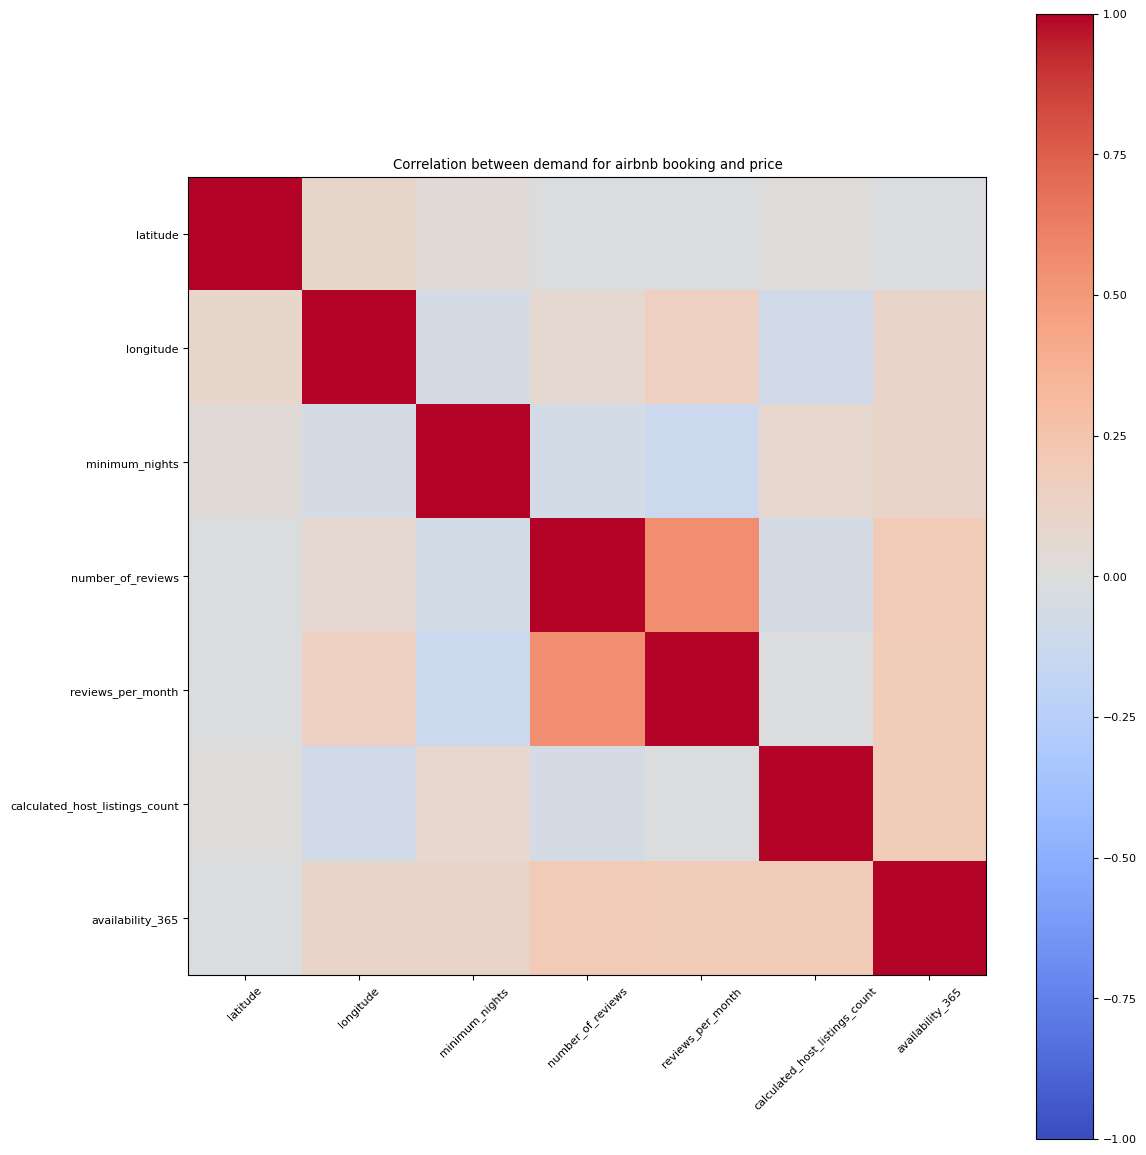

In [199]:
corr_matrix = x.corr()

# Set the font size for labels
plt.rc('font', size=8)

# Create a heatmap plot of the correlation matrix
plt.figure(figsize=(12, 12))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation between demand for airbnb booking and price')
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)
plt.tight_layout()
plt.show()

In [200]:
print(corr_matrix)

                                latitude  longitude  minimum_nights  \
latitude                        1.000000   0.088259        0.024893   
longitude                       0.088259   1.000000       -0.055414   
minimum_nights                  0.024893  -0.055414        1.000000   
number_of_reviews              -0.008559   0.054746       -0.069366   
reviews_per_month              -0.010117   0.146228       -0.121712   
calculated_host_listings_count  0.004340  -0.093348        0.073474   
availability_365               -0.021921   0.102573        0.101658   

                                number_of_reviews  reviews_per_month  \
latitude                                -0.008559          -0.010117   
longitude                                0.054746           0.146228   
minimum_nights                          -0.069366          -0.121712   
number_of_reviews                        1.000000           0.549699   
reviews_per_month                        0.549699           1.000000   

In [201]:

vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
  

vif_data["VIF"] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]
  
print(vif_data)

                          feature            VIF
0                        latitude  423541.903023
1                       longitude  423478.867244
2                  minimum_nights       1.152495
3               number_of_reviews       2.003975
4               reviews_per_month       2.450618
5  calculated_host_listings_count       1.089494
6                availability_365       1.977163


In [202]:
y.value_counts()

price
150     1596
100     1517
50      1188
60      1155
75      1095
        ... 
578        1
789        1
1795       1
1095       1
323        1
Name: count, Length: 581, dtype: int64

In [203]:
x = data.drop(['price'], axis=1)
y = data['price']

In [204]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 1/3, random_state=0)

# Fitting the Linear Regression model to the training dataset 

In [205]:
from sklearn.linear_model import LinearRegression  
regressor= LinearRegression()  
regressor.fit(x_train, y_train)    

LinearRegression()

In [206]:
y_pred = regressor.predict(x_test)

In [207]:
print('Coefficients:', regressor.coef_)
print('Intercept:', regressor.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, y_pred))

Coefficients: [ 1.59248622e+02 -7.43590441e+02 -1.10138633e-02 -1.93327041e-01
  3.85025177e-02  1.08842303e-01  1.72071868e-01]
Intercept: -61346.570074521806
Mean squared error (MSE): 33032.06
Coefficient of determination (R^2): 0.03


# Fitting the Random Forest Regression model to the training dataset

In [208]:
x = x.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

In [209]:
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

In [212]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Convert the NumPy array x to a Pandas DataFrame
x_df = pd.DataFrame(x)

# Select the categorical columns
categorical_cols = x_df.select_dtypes(include=['object']).columns

# Perform one-hot encoding for categorical variables
onehot_encoder = OneHotEncoder(sparse=False, drop='first')
x_encoded = pd.DataFrame(onehot_encoder.fit_transform(x_df[categorical_cols]))

# Get the feature names after one-hot encoding
feature_names = onehot_encoder.get_feature_names_out(categorical_cols)

# Assign the feature names to the encoded DataFrame columns
x_encoded.columns = feature_names

# Concatenate the encoded features with any remaining numerical features
x_encoded = pd.concat([x_encoded, x_df.select_dtypes(include=['int64', 'float64'])], axis=1)

# Now you can use x_encoded and y for linear regression


In [213]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=10, random_state=0)
regressor.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [227]:
y_pred = regressor.predict(x_test)

In [230]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate the coefficient of determination (R2)
r2 = r2_score(y_test, y_pred)

# Print the mean squared error and R2
print('Mean squared error (MSE): %.2f' % mse)
print('Coefficient of determination (R^2): %.2f' % r2)


Mean squared error (MSE): 35951.83
Coefficient of determination (R^2): -0.05
